---
**License**

 NC_CCL_mass_function

 Thu Apr 01 14:32:00 2021\
 Copyright  2021\
 Mariana Penna-Lima     <pennalima@unb.br> \
 Cinthia Nunes de Lima  <cinthia.n.lima@uel.br>

---
---

 NC_CCL_mass_function\
 Copyright (C) 2021 Mariana Penna-Lima <pennalima@unb.br>, Cinthia Nunes de Lima  <cinthia.n.lima@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

<a class="anchor" id="contents"></a>
# Contents

### 1. [Packages](#libraries)
### 2. [Cosmological constants](#constants)
### 3. [Libraries settings](#Initializing)
### 4. [Linear matter power spectrum](#powerspectrum)
### 5. [Multiplicity functions tests](#multiplicity)
####     5.1 [Mass function and plot](#mass)
####     5.2 [Time tests](#5.2)
####     5.3 [Note](#5.3)
### 6. [Tinker multiplicity function tests](#tinkertests)
####     6.1 [Results](#6.1)
####         6.1.1 [Plot of mass function and relative error, between CCL and NumCosmo, for z=0:](#6.1.1)
####         6.1.2 [Plot of mass function and relative error, between CCL and NumCosmo, for z=1:](#6.1.2)
####         6.1.3 [Plot of mass function and relative error, between CCL and NumCosmo, for z=2:](#6.1.3)
####     6.2 [Note](#6.2)
### 7. [Bocquet multiplicity function tests](#bocquet)
####     7.1 [Results](#7.1)

<a class="anchor" id="libraries"></a>
## 1.  [Packages](#contents)
***

In the cell below, we import the libraries `CCL` and `NumCosmo` for comparison between their mass functions for different multiplicity functions.

To import `NumCosmo`, we should import `GObject`. This is important because `GObject` help us to maps the C language in other languages, like python.

The package `sys` is related to the manipulation and obtaining information from the python environment. The packages `numpy` and `math` help us with the calculations, gives us access to mathematical functions.




In [2]:
# NumCosmo
from numcosmo_py import Nc, Ncm
from numcosmo_py.ccl.nc_ccl import create_nc_obj, CCLParams, dsigmaM_dlnM
from numcosmo_py.ccl.comparison import compare_ccl_nc_func

# CCL
import pyccl
from pyccl.halos.massdef import MassDef

import sys
import numpy as np
import math
import matplotlib.pyplot as plt

import sys

<a class="anchor" id="constants"></a>
## 2. [Cosmological constants](#contents)
***
In this cell below we fix the cosmological constants to avoid conflits in the calculations and comparisons between the libraries.


$\Omega_{C}$ = 0.262 The density fraction at z=0 of CDM.<br>
$\Omega_{b}$ = 0.049 The density fraction at z=0 of baryons.<br>
$\Omega_{k}$ = 0.0 The curvature density fraction at z=0.<br>
$H_{0 }$ = 67.66   The Hubble constant.<br>
$Tcmb_{0}$  = 2.7255 The temperature at z=0 of CMB.<br>
$A_{s} = 2.1E-9$  The primordial normalization of the power spectrum at k=0.05 Mpc −1.<br>
$\sigma_{8}$ = 0.8277 The normalization of the power spectrum today. <br>
$n_{s}$ = 0.96 Scalar spectral index.<br>
$N_{eff}$ = 0.0 3.046 effective number of massless+massive neutrinos present at recombination.<br>
$\omega_{0}$ = -1.0 First order term of the dark energy equation of state.<br>
$\omega_{a}$ = 0.0 Second order term of the dark energy equation of state.<br>


In [3]:
Omega_c = 0.262
Omega_b = 0.049
Omega_k = 0.0
H0 = 67.66
h = H0 / 100.0
Tcmb0 = 2.7255
A_s = 2.1e-9
sigma8 = 0.8277
n_s = 0.96
Neff = 3.046
w0 = -1.0
wa = 0.0

# CCL uses linear interpolation for the Tinker mass function. Set here to False
# To see the error in comparison with the the cubic interpolation proposed in
# the paper
Tinker_lin_interp = True

<a class="anchor" id="Initializing"></a>
## 3. [Libraries settings](#contents)

***
First we create the cosmology object  of CCL, `cosmo_ccl`.Next, we initialize the `NumCosmo` using `Ncm.cfg_init ()`, this function should be placed before any NumCosmo function, and then we create the cosmology object of `NumCosmo`.

We also create the homogeneous and isotropic object, ` hiprim `, this is necessary to calculate the linear power spectrum P(k).





<a class="anchor" id="powerspectrum"></a>
## 4. [Linear matter power spectrum](#contents)
***

The linear matter power spectrum P(k) describes the linear evolution of the density pertubations. To calculate it we use the transfer function T(k) and apply a tophat filter.

The code `TransferFunc.new_from_name` returns a new `NcTransferFunc`, whose type is defined in this case by "NcTransferFuncEH" .
    
The transfer function, T(k), is defined as,
$$
T(k)\equiv \frac{\hat{\delta}(k,z=0)}{\hat{\delta}(k,z=\infty)} \frac {\hat{\delta}(k=0,z=\infty)}{\hat{\delta}(k=0,z=0)}
$$

$\hat{\delta}(k,z) $ is the density pertubation and, by definition, $\lim_{k\rightarrow 0} T (k) \rightarrow 1$.

We create a new linear matter power spectrum object using `PowspecMLTransfer.new (tf)` calculated over a range of small to large scales of the wavenumber,k, and apply a tophat filter using ` Ncm.PowspecFilter.new (psml, Ncm.PowspecFilterType.TOPHAT)`.

In [13]:
# CCL Cosmology
ccl_params = CCLParams()
ccl_params.set_high_prec_params()

ccl_cosmo = pyccl.Cosmology(
    Omega_c=Omega_c,
    Omega_b=Omega_b,
    Neff=Neff,
    h=H0 / 100.0,
    sigma8=sigma8,
    n_s=n_s,
    Omega_k=Omega_k,
    w0=w0,
    wa=wa,
    T_CMB=Tcmb0,
    m_nu=[0.00, 0.0, 0.0],
    transfer_function="eisenstein_hu",
    matter_power_spectrum="linear",
)
Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

nc_cosmo = create_nc_obj(ccl_cosmo)
dist = nc_cosmo.dist
cosmo = nc_cosmo.cosmo
psf = nc_cosmo.psf_tophat

<a class="anchor" id="multiplicity"></a>
## 5. [Multiplicity functions tests](#contents)
***

The multiplicity function contains information about the collapse process and halo formation. In the cell above we  defined the multiplicity functions objects for different formalisms. The form of them can be consulted in the following papers:

Press-Schechter (1974) [(1974ApJ...187..425P)](http://articles.adsabs.harvard.edu/pdf/1974ApJ...187..425P>);

Sheth-Tormen (1899)[(arXiv:astro-ph/9901122)](https://arxiv.org/pdf/astro-ph/9901122.pdf);

Jenkins (2001) [(arXiv:astro-ph/0005260)](https://arxiv.org/pdf/astro-ph/0005260.pdf);

Tinker (2008) [(astro-ph/0803.2706)](https://arxiv.org/pdf/0803.2706.pdf);

Tinker (2010) [(arXiv:1001.3162)](https://arxiv.org/pdf/1001.3162.pdf).



In [7]:
# CCL Mass definitions
# Delta=200 (matter).
hmd_200m = pyccl.halos.MassDef200m

# Delta=200 (critical).
hmd_200c = pyccl.halos.MassDef200c

# Delta=500 (matter).
hmd_500m = pyccl.halos.MassDef(500, "matter")

# Virial overdensity
hmd_vir = pyccl.halos.MassDefVir

# FoF mass definition
hmd_fof = pyccl.halos.MassDefFof

In [8]:
# CCL multiplicity functions

# Press & Schechter mass function
ccl_hmf_PS = pyccl.halos.MassFuncPress74(mass_def=hmd_fof)

# Sheth & Tormen mass function
ccl_hmf_ST = pyccl.halos.MassFuncSheth99(mass_def=hmd_fof)

# Jenkins 2001 mass function
ccl_hmf_Jenkins = pyccl.halos.MassFuncJenkins01()

# Tinker 2008 mass function
ccl_hmf_T08 = pyccl.halos.MassFuncTinker08(mass_def=hmd_200m)

# Tinker 2010 mass function
ccl_hmf_T10 = pyccl.halos.MassFuncTinker10()

# NumCosmo multiplicity functions

# Press & Schechter
hmf_PS = Nc.MultiplicityFuncPS.new()

# Sheth & Tormen
hmf_ST = Nc.MultiplicityFuncST.new()

# Jenkins
hmf_Jenkins = Nc.MultiplicityFuncJenkins.new()

# Tinker 2008
hmf_TM08 = Nc.MultiplicityFuncTinker.new()
hmf_TM08.set_linear_interp(Tinker_lin_interp)

# Tinker 2010
hmf_T10 = Nc.MultiplicityFuncTinkerMeanNormalized.new()

#
# New mass function object using the objects defined above.
#
mf_PS = Nc.HaloMassFunction.new(dist, psf, hmf_PS)
mf_ST = Nc.HaloMassFunction.new(dist, psf, hmf_ST)
mf_Jenkins = Nc.HaloMassFunction.new(dist, psf, hmf_Jenkins)
mf_TM08 = Nc.HaloMassFunction.new(dist, psf, hmf_TM08)
mf_T10 = Nc.HaloMassFunction.new(dist, psf, hmf_T10)

In [9]:
# Array of masses
m_arr = np.geomspace(1e10, 1e15, 128)

# Array of redshifts
z_arr = np.linspace(0.0, 1.0, 16)

In [10]:
psf.prepare(cosmo)
sigma8_nc = psf.eval_sigma(0.0, 8.0 / h)

mf_PS.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
mf_PS.prepare(cosmo)
mf_ST.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
mf_ST.prepare(cosmo)
mf_Jenkins.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
mf_Jenkins.prepare(cosmo)
mf_TM08.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
mf_TM08.prepare(cosmo)
mf_T10.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
mf_T10.prepare(cosmo)

In [11]:
def cmp_double(desc, m1, m2, x1, x2):
    print(
        "%s: %s = % 22.15g, %s = % 22.15g, CMP: %9.2e"
        % (desc, m1, x1, m2, x2, math.fabs(x1 / x2 - 1.0))
    )

<a class="anchor" id="mass"></a>
### 5.1 [Mass function and plot](#contents)

In the cell below we created a list `multiplicity_functions` of pairs, containing the multiplicity function of ` ccl` and `numcosmo`, respectively, for each formalism. Then we use the multiplicity functions to calculate the mass function in each case.

We plot first the graph of mass functions calculated using data of ccl and the second graph plotted is the difference of the mass function of libraries, for each formalism.


<Figure size 640x480 with 0 Axes>

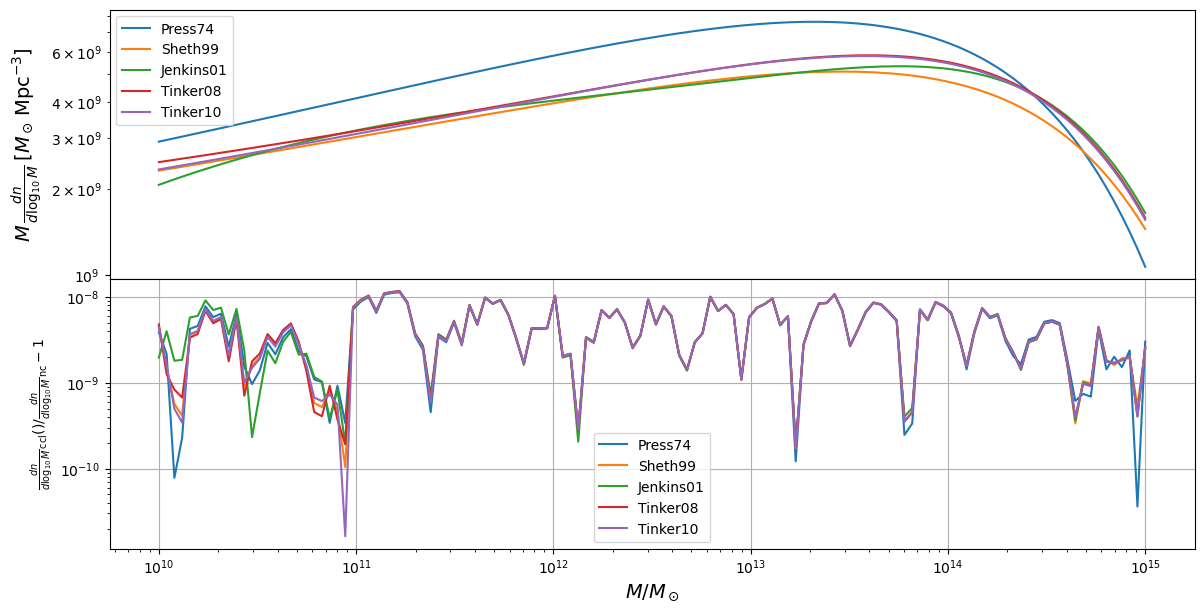

In [14]:
plt.figure()
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={"hspace": 0}, figsize=(14, 7))

multiplicity_functions = [
    (ccl_hmf_PS, mf_PS),
    (ccl_hmf_ST, mf_ST),
    (ccl_hmf_Jenkins, mf_Jenkins),
    (ccl_hmf_T08, mf_TM08),
    (ccl_hmf_T10, mf_T10),
]

# CCL
for ccl_mf_obj, nc_mf_obj in multiplicity_functions:
    ccl_mf = ccl_mf_obj(ccl_cosmo, m_arr, 1.0)
    ccl_nm = m_arr * ccl_mf
    axs[0].plot(m_arr, ccl_nm, label=ccl_mf_obj.name)

    # NumCosmo
    nc_mf = [
        nc_mf_obj.dn_dlnM(cosmo, logm, 0.0) * math.log(10.0) for logm in np.log(m_arr)
    ]
    nc_nm = m_arr * nc_mf

    axs[1].plot(m_arr, np.abs(ccl_nm / nc_nm - 1.0), "-", label=ccl_mf_obj.name)


# Plot settings
axs[0].set_xscale("log")
axs[0].set_yscale("log")
# axs[0].ylim([1.0E9,8.5E9])
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$M/M_\odot$", fontsize=14)
axs[0].set_ylabel(
    r"$M\,\frac{dn}{d\log_{10}M}\,[M_\odot\,{\rm Mpc}^{-3}]$", fontsize=14
)
axs[1].set_ylabel(
    r"$\frac{dn}{d\log_{10}M}_{\mathrm{ccl}} () / \frac{dn}{d\log_{10}M}_{\mathrm{nc}} - 1$"
)
axs[0].legend(loc="best")

axs[1].legend(loc="best")
axs[1].grid()

plt.show()

<a class="anchor" id="5.2"></a>
### 5.2 [Time tests:](#contents)

### CCL

In [15]:
%timeit [nc_mf_obj.dn_dlnM (cosmo, logm, 0.0) * math.log(10.0) for logm in np.log(m_arr)]

87.4 μs ± 2.89 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


<a class="anchor" id="5.3"></a>
### 5.3 [Note](#contents)

For the mass functions analyzed in this test, note that the precision and execution time of the codes are close.  

<a class="anchor" id="tinkertests"></a>
## 6. [Tinker (2008) multiplicity function tests](#contents)
***

###  NumCosmo

In [16]:
# Tinker MEAN

# Delta200
hmf_TM200 = Nc.MultiplicityFuncTinker.new()
hmf_TM200.set_linear_interp(Tinker_lin_interp)
hmf_TM200.set_mdef(Nc.MultiplicityFuncMassDef.MEAN)
hmf_TM200.set_Delta(200.0)


# Delta300
hmf_TM300 = Nc.MultiplicityFuncTinker.new()
hmf_TM300.set_linear_interp(Tinker_lin_interp)
hmf_TM300.set_mdef(Nc.MultiplicityFuncMassDef.MEAN)
hmf_TM300.set_Delta(300.0)

# Delta400
hmf_TM400 = Nc.MultiplicityFuncTinker.new()
hmf_TM400.set_linear_interp(Tinker_lin_interp)
hmf_TM400.set_mdef(Nc.MultiplicityFuncMassDef.MEAN)
hmf_TM400.set_Delta(400.0)

# Delta600
hmf_TM600 = Nc.MultiplicityFuncTinker.new()
hmf_TM600.set_linear_interp(Tinker_lin_interp)
hmf_TM600.set_mdef(Nc.MultiplicityFuncMassDef.MEAN)
hmf_TM600.set_Delta(600.0)

# Delta800
hmf_TM800 = Nc.MultiplicityFuncTinker.new()
hmf_TM800.set_linear_interp(Tinker_lin_interp)
hmf_TM800.set_mdef(Nc.MultiplicityFuncMassDef.MEAN)
hmf_TM800.set_Delta(800.0)

# Delta1200
hmf_TM1200 = Nc.MultiplicityFuncTinker.new()
hmf_TM1200.set_linear_interp(Tinker_lin_interp)
hmf_TM1200.set_mdef(Nc.MultiplicityFuncMassDef.MEAN)
hmf_TM1200.set_Delta(1200.0)

# Delta1600
hmf_TM1600 = Nc.MultiplicityFuncTinker.new()
hmf_TM1600.set_linear_interp(Tinker_lin_interp)
hmf_TM1600.set_mdef(Nc.MultiplicityFuncMassDef.MEAN)
hmf_TM1600.set_Delta(1600.0)

# Delta2400
hmf_TM2400 = Nc.MultiplicityFuncTinker.new()
hmf_TM2400.set_linear_interp(Tinker_lin_interp)
hmf_TM2400.set_mdef(Nc.MultiplicityFuncMassDef.MEAN)
hmf_TM2400.set_Delta(2400.0)

# Delta3200
hmf_TM3200 = Nc.MultiplicityFuncTinker.new()
hmf_TM300.set_mdef(Nc.MultiplicityFuncMassDef.MEAN)
hmf_TM3200.set_Delta(3200.0)

In [17]:
# Tinker CRITICAL

# Delta200
hmf_TC200 = Nc.MultiplicityFuncTinker.new()
hmf_TC200.set_linear_interp(Tinker_lin_interp)
hmf_TC200.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
hmf_TC200.set_Delta(200.0)

# Delta300
hmf_TC300 = Nc.MultiplicityFuncTinker.new()
hmf_TC300.set_linear_interp(Tinker_lin_interp)
hmf_TC300.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
hmf_TC300.set_Delta(300.0)

# Delta400
hmf_TC400 = Nc.MultiplicityFuncTinker.new()
hmf_TC400.set_linear_interp(Tinker_lin_interp)
hmf_TC400.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
hmf_TC400.set_Delta(400.0)

# Delta600
hmf_TC600 = Nc.MultiplicityFuncTinker.new()
hmf_TC600.set_linear_interp(Tinker_lin_interp)
hmf_TC600.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
hmf_TC600.set_Delta(600.0)

# Delta800
hmf_TC800 = Nc.MultiplicityFuncTinker.new()
hmf_TC800.set_linear_interp(Tinker_lin_interp)
hmf_TC800.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
hmf_TC800.set_Delta(800.0)

# Delta1200
hmf_TC1200 = Nc.MultiplicityFuncTinker.new()
hmf_TC1200.set_linear_interp(Tinker_lin_interp)
hmf_TC1200.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
hmf_TC1200.set_Delta(1200.0)

# Delta1600
hmf_TC1600 = Nc.MultiplicityFuncTinker.new()
hmf_TC1600.set_linear_interp(Tinker_lin_interp)
hmf_TC1600.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
hmf_TC1600.set_Delta(1600.0)

# Delta2400
hmf_TC2400 = Nc.MultiplicityFuncTinker.new()
hmf_TC2400.set_linear_interp(Tinker_lin_interp)
hmf_TC2400.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
hmf_TC2400.set_Delta(2400.0)

# Delta3200
hmf_TC3200 = Nc.MultiplicityFuncTinker.new()
hmf_TC3200.set_linear_interp(Tinker_lin_interp)
hmf_TC300.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
hmf_TC3200.set_Delta(3200.0)

Configurations of NumCosmo Multiplicity Functions

In [18]:
nc_TM200 = Nc.HaloMassFunction.new(dist, psf, hmf_TM200)
nc_TM200.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TM200.prepare(cosmo)

nc_TM300 = Nc.HaloMassFunction.new(dist, psf, hmf_TM300)
nc_TM300.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TM300.prepare(cosmo)

nc_TM400 = Nc.HaloMassFunction.new(dist, psf, hmf_TM400)
nc_TM400.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TM400.prepare(cosmo)

nc_TM600 = Nc.HaloMassFunction.new(dist, psf, hmf_TM600)
nc_TM600.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TM600.prepare(cosmo)

nc_TM800 = Nc.HaloMassFunction.new(dist, psf, hmf_TM800)
nc_TM800.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TM800.prepare(cosmo)

nc_TM1200 = Nc.HaloMassFunction.new(dist, psf, hmf_TM1200)
nc_TM1200.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TM1200.prepare(cosmo)

nc_TM1600 = Nc.HaloMassFunction.new(dist, psf, hmf_TM1600)
nc_TM1600.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TM1600.prepare(cosmo)

nc_TM2400 = Nc.HaloMassFunction.new(dist, psf, hmf_TM2400)
nc_TM2400.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TM2400.prepare(cosmo)

nc_TM3200 = Nc.HaloMassFunction.new(dist, psf, hmf_TM3200)
nc_TM3200.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TM3200.prepare(cosmo)

nc_TC200 = Nc.HaloMassFunction.new(dist, psf, hmf_TC200)
nc_TC200.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TC200.prepare(cosmo)

nc_TC300 = Nc.HaloMassFunction.new(dist, psf, hmf_TC300)
nc_TC300.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TC300.prepare(cosmo)

nc_TC400 = Nc.HaloMassFunction.new(dist, psf, hmf_TC400)
nc_TC400.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TC400.prepare(cosmo)

nc_TC600 = Nc.HaloMassFunction.new(dist, psf, hmf_TC600)
nc_TC600.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TC600.prepare(cosmo)

nc_TC800 = Nc.HaloMassFunction.new(dist, psf, hmf_TC800)
nc_TC800.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TC800.prepare(cosmo)

nc_TC1200 = Nc.HaloMassFunction.new(dist, psf, hmf_TC1200)
nc_TC1200.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TC1200.prepare(cosmo)

nc_TC1600 = Nc.HaloMassFunction.new(dist, psf, hmf_TC1600)
nc_TC1600.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TC1600.prepare(cosmo)

nc_TC2400 = Nc.HaloMassFunction.new(dist, psf, hmf_TC2400)
nc_TC2400.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TC2400.prepare(cosmo)

nc_TC3200 = Nc.HaloMassFunction.new(dist, psf, hmf_TC3200)
nc_TC3200.set_eval_limits(cosmo, math.log(1e11), math.log(1e16), 0.0, 2.0)
nc_TC3200.prepare(cosmo)

### CCL

In [22]:
# CCL

# MEAN

# Delta200
ccl_mdef_TM200 = MassDef(Delta=200, rho_type="matter")
ccl_TM200 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TM200)

# Delta300
ccl_mdef_TM300 = MassDef(Delta=300, rho_type="matter")
ccl_TM300 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TM300)

# Delta400
ccl_mdef_TM400 = MassDef(Delta=400, rho_type="matter")
ccl_TM400 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TM400)

# Delta600
ccl_mdef_TM600 = MassDef(Delta=600, rho_type="matter")
ccl_TM600 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TM600)

# Delta800
ccl_mdef_TM800 = MassDef(Delta=800, rho_type="matter")
ccl_TM800 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TM800)

# Delta1200
ccl_mdef_TM1200 = MassDef(Delta=1200, rho_type="matter")
ccl_TM1200 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TM1200)

# Delta1600
ccl_mdef_TM1600 = MassDef(Delta=1600, rho_type="matter")
ccl_TM1600 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TM1600)

# Delta2400
ccl_mdef_TM2400 = MassDef(Delta=2400, rho_type="matter")
ccl_TM2400 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TM2400)

# Delta3200
ccl_mdef_TM3200 = MassDef(Delta=3200, rho_type="matter")
ccl_TM3200 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TM3200)

# CRITICAL

# Delta200
ccl_mdef_TC200 = MassDef(Delta=200, rho_type="critical")
ccl_TC200 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TC200)

# Delta300
ccl_mdef_TC300 = MassDef(Delta=300, rho_type="critical")
ccl_TC300 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TC300)

# Delta400
ccl_mdef_TC400 = MassDef(Delta=400, rho_type="critical")
ccl_TC400 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TC400)

# Delta600
ccl_mdef_TC600 = MassDef(Delta=600, rho_type="critical")
ccl_TC600 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TC600)

# Delta800
ccl_mdef_TC800 = MassDef(Delta=800, rho_type="critical")
ccl_TC800 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TC800)

# Delta1200
ccl_mdef_TC1200 = MassDef(Delta=1200, rho_type="critical")
ccl_TC1200 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TC1200)

# Delta1600
ccl_mdef_TC1600 = MassDef(Delta=1600, rho_type="critical")
ccl_TC1600 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TC1600)

# Delta2400
ccl_mdef_TC2400 = MassDef(Delta=2400, rho_type="critical")
ccl_TC2400 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TC2400)

# Delta3200
ccl_mdef_TC3200 = MassDef(Delta=3200, rho_type="critical")
ccl_TC3200 = pyccl.halos.MassFuncTinker08(mass_def=ccl_mdef_TC3200)

In [23]:
Tinker_CCL_NC = [
    (ccl_TM200, nc_TM200, "200-Mean"),
    (ccl_TM300, nc_TM300, "300-Mean"),
    (ccl_TM400, nc_TM400, "400-Mean"),
    (ccl_TM600, nc_TM600, "600-Mean"),
    (ccl_TM800, nc_TM800, "800-Mean"),
    (ccl_TM1200, nc_TM1200, "1200-Mean"),
    (ccl_TM1600, nc_TM1600, "1600-Mean"),
    (ccl_TM2400, nc_TM2400, "2400-Mean"),
    (ccl_TM3200, nc_TM3200, "3200-Mean"),
    (ccl_TC200, nc_TC200, "200-Critical"),
    (ccl_TC300, nc_TC300, "300-Critical"),
    (ccl_TC400, nc_TC400, "400-Critical"),
    (ccl_TC600, nc_TC600, "600-Critical"),
    (ccl_TC800, nc_TC800, "800-Critical"),
    (ccl_TC1200, nc_TC1200, "1200-Critical"),
    (ccl_TC1600, nc_TC1600, "1600-Critical"),
    (ccl_TC2400, nc_TC2400, "2400-Critical"),
    (ccl_TC3200, nc_TC3200, "3200-Critical"),
]

<a class="anchor" id="6.1"></a>
## 6.1 [Results](#contents)

<a class="anchor" id="6.1.1"></a>
### 6.1.1 [Plot of mass function and relative error, between CCL and NumCosmo, for z=0:](#contents)


<Figure size 640x480 with 0 Axes>

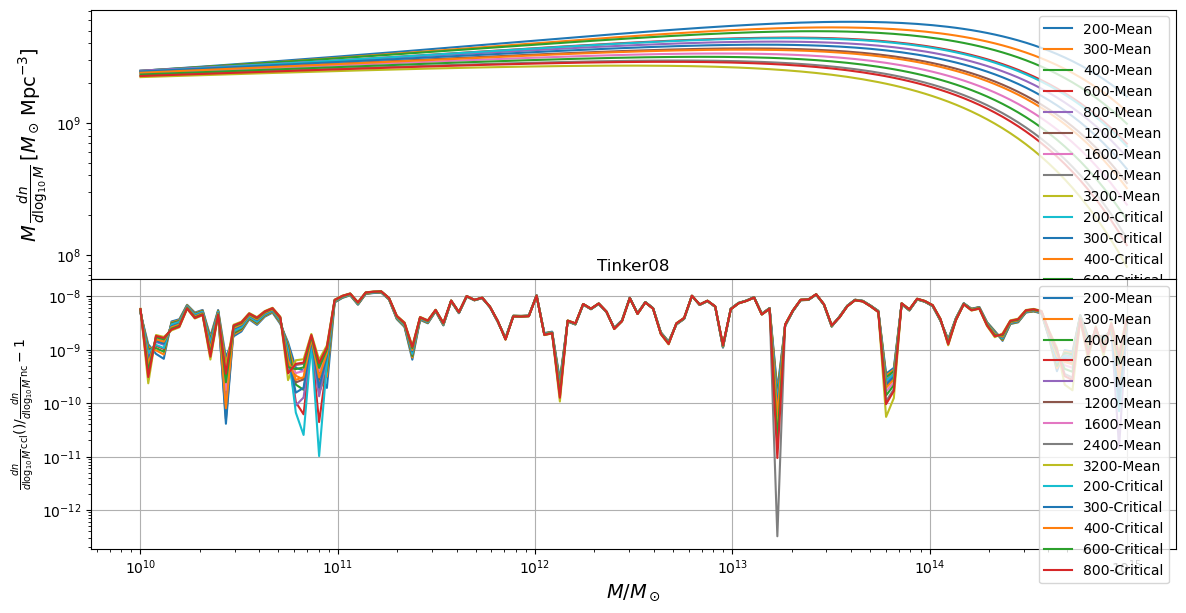

In [24]:
plt.figure()
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={"hspace": 0}, figsize=(14, 7))

z = 0.0
a = 1.0 / (1.0 + z)

# CCL
for ccl_mfobj, nc_mfobj, mfobj_name in Tinker_CCL_NC[:-4]:
    # print(mfobj_name, ccl_mfobj, nc_mfobj,ccl_mfobj._get_Delta_m(cosmo_ccl, a))
    ccl_tmf0 = ccl_mfobj(ccl_cosmo, m_arr, a)
    ccl_tnm0 = m_arr * ccl_tmf0

    axs[0].plot(m_arr, ccl_tnm0, label=mfobj_name)

    # NumCosmo
    nc_tmf0 = [
        nc_mfobj.dn_dlnM(cosmo, logm, z) * math.log(10.0) for logm in np.log(m_arr)
    ]
    nc_tnm0 = m_arr * nc_tmf0

    axs[1].plot(m_arr, np.abs(ccl_tnm0 / nc_tnm0 - 1.0), "-", label=mfobj_name)

# Plot settings

axs[0].set_xscale("log")
axs[0].set_yscale("log")
# axs[0].ylim([1.0E9,8.5E9])
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$M/M_\odot$", fontsize=14)
axs[0].set_ylabel(
    r"$M\,\frac{dn}{d\log_{10}M}\,[M_\odot\,{\rm Mpc}^{-3}]$", fontsize=14
)
axs[1].set_ylabel(
    r"$\frac{dn}{d\log_{10}M}_{\mathrm{ccl}} () / \frac{dn}{d\log_{10}M}_{\mathrm{nc}} - 1$"
)
axs[0].legend(loc="best")

axs[1].legend(loc="best")
axs[1].grid()

plt.title("Tinker08")
plt.show()

<a class="anchor" id="6.1.2"></a>
### 6.1.1 [Plot of mass function and relative error, between CCL and NumCosmo, for z=1:](#contents)


<Figure size 640x480 with 0 Axes>

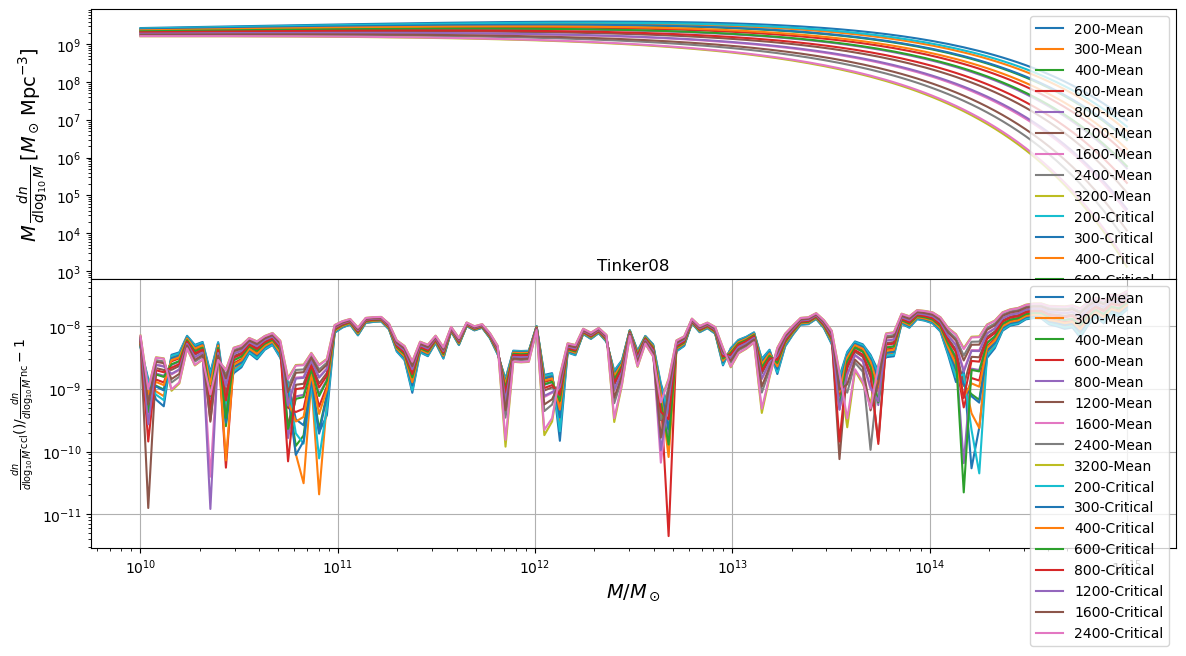

In [25]:
plt.figure()
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={"hspace": 0}, figsize=(14, 7))

z = 1.0
a = 1.0 / (1.0 + z)

# CCL
for ccl_mfobj, nc_mfobj, mfobj_name in Tinker_CCL_NC[:-1]:
    # print(mfobj_name, ccl_mfobj, nc_mfobj,ccl_mfobj._get_Delta_m(cosmo_ccl, a))
    ccl_tmf1 = ccl_mfobj(ccl_cosmo, m_arr, a)
    ccl_tnm1 = m_arr * ccl_tmf1

    axs[0].plot(m_arr, ccl_tnm1, label=mfobj_name)

    # NumCosmo
    nc_tmf1 = [
        nc_mfobj.dn_dlnM(cosmo, logm, z) * math.log(10.0) for logm in np.log(m_arr)
    ]
    nc_tnm1 = m_arr * nc_tmf1

    axs[1].plot(m_arr, np.abs(ccl_tnm1 / nc_tnm1 - 1.0), "-", label=mfobj_name)

# Plot settings

axs[0].set_xscale("log")
axs[0].set_yscale("log")
# axs[0].ylim([1.0E9,8.5E9])
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$M/M_\odot$", fontsize=14)
axs[0].set_ylabel(
    r"$M\,\frac{dn}{d\log_{10}M}\,[M_\odot\,{\rm Mpc}^{-3}]$", fontsize=14
)
axs[1].set_ylabel(
    r"$\frac{dn}{d\log_{10}M}_{\mathrm{ccl}} () / \frac{dn}{d\log_{10}M}_{\mathrm{nc}} - 1$"
)
axs[0].legend(loc="best")

axs[1].legend(loc="best")
axs[1].grid()

plt.title("Tinker08")
plt.show()

<a class="anchor" id="6.1.3"></a>
### 6.1.1 [Plot of mass function and relative error, between CCL and NumCosmo, for z=2:](#contents)


<Figure size 640x480 with 0 Axes>

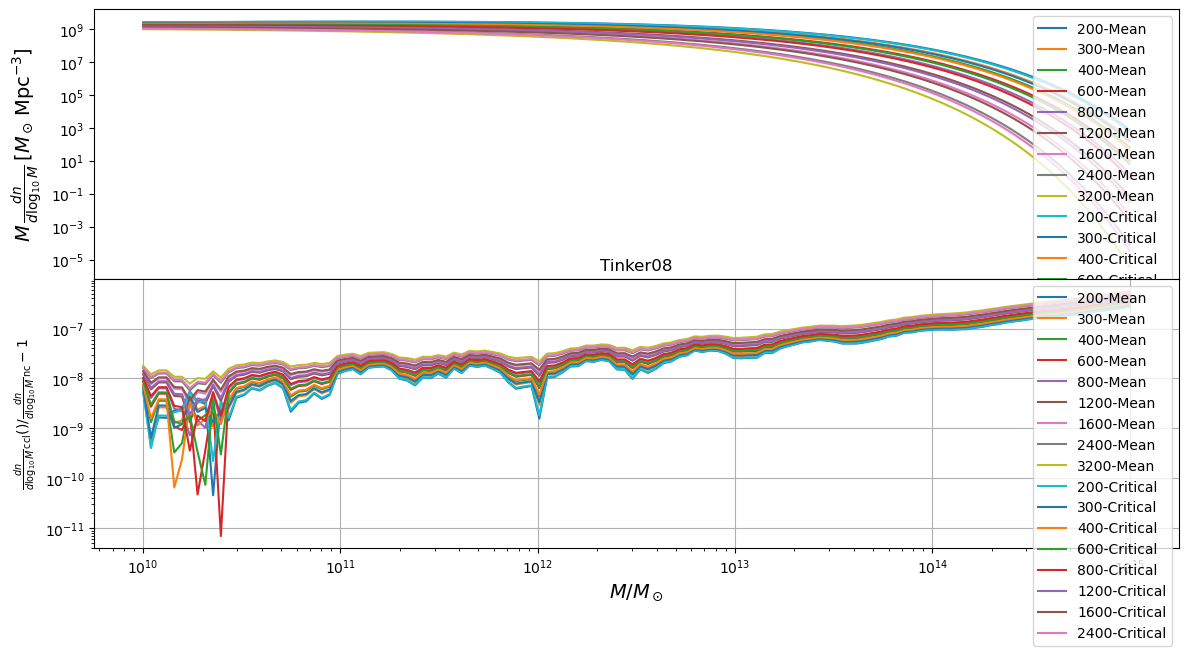

In [26]:
plt.figure()
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={"hspace": 0}, figsize=(14, 7))

z = 2.0
a = 1.0 / (1.0 + z)

# CCL
for ccl_mfobj, nc_mfobj, mfobj_name in Tinker_CCL_NC[:-1]:
    # print(mfobj_name, ccl_mfobj, nc_mfobj,ccl_mfobj._get_Delta_m(cosmo_ccl, a))
    ccl_tmf1 = ccl_mfobj(ccl_cosmo, m_arr, a)
    ccl_tnm1 = m_arr * ccl_tmf1

    axs[0].plot(m_arr, ccl_tnm1, label=mfobj_name)

    # NumCosmo
    nc_tmf1 = [
        nc_mfobj.dn_dlnM(cosmo, logm, z) * math.log(10.0) for logm in np.log(m_arr)
    ]
    nc_tnm1 = m_arr * nc_tmf1

    axs[1].plot(m_arr, np.abs(ccl_tnm1 / nc_tnm1 - 1.0), "-", label=mfobj_name)

# Plot settings

axs[0].set_xscale("log")
axs[0].set_yscale("log")
# axs[0].ylim([1.0E9,8.5E9])
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$M/M_\odot$", fontsize=14)
axs[0].set_ylabel(
    r"$M\,\frac{dn}{d\log_{10}M}\,[M_\odot\,{\rm Mpc}^{-3}]$", fontsize=14
)
axs[1].set_ylabel(
    r"$\frac{dn}{d\log_{10}M}_{\mathrm{ccl}} () / \frac{dn}{d\log_{10}M}_{\mathrm{nc}} - 1$"
)
axs[0].legend(loc="best")

axs[1].legend(loc="best")
axs[1].grid()

plt.title("Tinker08")
plt.show()